In [1]:
from __future__ import print_function

import sys, os
import numpy as np
from time import time
import matplotlib.pyplot as plt 

sys.path.append('/home/xilinx')
os.environ['XILINX_XRT'] = '/usr'
from pynq import Overlay
from pynq import allocate

In [2]:
print("Entry:", sys.argv[0])
print("System argument(s):", len(sys.argv))

print("Start of \"" + sys.argv[0] + "\"")

overlay = Overlay('/home/xilinx/jupyter_notebooks/Untitled Folder/design_1.bit')

Entry: /usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py"


In [3]:
from pynq import ps

print(ps.Clocks.fclk0_mhz)
print(ps.Clocks.cpu_mhz)

62.5
650.0


In [4]:
ip = overlay.model_0
mmio = ip.mmio
register_map = ip.register_map
registers = register_map._register_classes

In [5]:
for name, reg in registers.items():
    print(name, reg)

CTRL (<class 'pynq.registers.RegisterCTRL'>, 0, 32, None, None, 'read-write')
GIER (<class 'pynq.registers.RegisterGIER'>, 4, 32, None, None, 'read-write')
IP_IER (<class 'pynq.registers.RegisterIP_IER'>, 8, 32, None, None, 'read-write')
IP_ISR (<class 'pynq.registers.RegisterIP_ISR'>, 12, 32, None, None, 'read-write')
data_in_noise_1 (<class 'pynq.registers.Registerdata_in_noise_1'>, 16, 32, None, None, 'write-only')
data_in_noise_2 (<class 'pynq.registers.Registerdata_in_noise_2'>, 20, 32, None, None, 'write-only')
data_out_1 (<class 'pynq.registers.Registerdata_out_1'>, 28, 32, None, None, 'write-only')
data_out_2 (<class 'pynq.registers.Registerdata_out_2'>, 32, 32, None, None, 'write-only')


In [6]:
input_buffer_size = 100
output_buffer_size = 784

input_buffer = allocate(shape=(input_buffer_size, ), dtype=np.uint8)
output_buffer = allocate(shape=(output_buffer_size, ), dtype=np.float32)
register_map.data_in_noise_1.data_in_noise = input_buffer.device_address
register_map.data_out_1.data_out = output_buffer.device_address

In [7]:
def hw(data_in):
    input_buffer[:len(data_in)] = data_in
    
    register_map.CTRL.AP_START = 1
    
    while(register_map.CTRL.AP_DONE == 0):
        pass
    
    return output_buffer

In [63]:
images_num = 100

In [64]:
np.random.seed(1)

test_data = np.random.randint(0, 127, (images_num, 100), dtype=np.uint8)
test_data

array([[ 37, 116,  65, ...,  32,   6, 113],
       [106,  77,  76, ..., 113,   4, 101],
       [ 81, 120,  66, ...,  28, 105, 109],
       ...,
       [115,   7,  37, ...,  70,   1,  19],
       [126, 109,  31, ..., 114, 120,  62],
       [  6,  87,  31, ..., 115,  79,  90]], dtype=uint8)

In [65]:
img_list = []

start = time()
for i in range(images_num):
    out = hw(test_data[i])
    img_list.append(np.array(out))
end = time()

In [66]:
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(np.array(images).shape[0])))

    plt.rcParams['figure.figsize'] = (10, 8)
    
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28), cmap='gray')

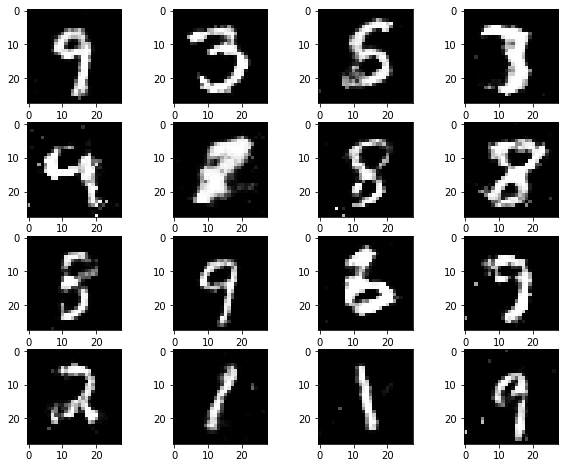

In [67]:
show_images(img_list[:16])

In [68]:
print('Time: '+str(end - start)+'s')
print('FPS: ', 1/((end - start) / images_num))

Time: 0.9309728145599365s
FPS:  107.4145221386182
